In [1]:
# Copyright 2020 Jaime Tierney, Adam Luchies, and Brett Byram

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the license at

# http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and 
# limitations under the License.

# INSTALL NECESSARY PACKAGES PRIOR TO RUNNING THIS NOTEBOOK
# pytorch
# jupyter 
# numpy
# scipy
# matplotlib
# pandas
# h5py

# IMPORT PYTHON PACKAGES
import torch
import os
import numpy as np
from torch import nn
import time
import argparse
import sys
import h5py
from scipy.io import loadmat
from scipy.io import savemat
from scipy.signal import hilbert
import matplotlib.pyplot as plt

# IMPORT FUNCTIONS FROM PROVIDED SOURCE CODE
sys.path.insert(0,'src')
from utils import read_model_params
from model import FullyConnectedNet

In [2]:
# SPECIFY PATH TO MODEL (THIS IS ALSO OUTPUT PATH)
model_path = 'models/model_1/k_8/'

# LOAD IN MODEL PARAMS
model_params = read_model_params(model_path+'model_params.txt')

# PROVIDE TEST DATA FILE INFO
test_data_path = 'test_data/'
test_data_name = 'chandat_phantom_5mm_70mm'

In [3]:
# SPECIFY CUDA AVAILABILITY
print('torch.cuda.is_available(): ' + str(torch.cuda.is_available()))
if model_params['cuda'] and torch.cuda.is_available():
    print('Using ' + str(torch.cuda.get_device_name(0)))
else:
    print('Not using CUDA')
    model_params['cuda']=False
device = torch.device("cuda:0" if model_params['cuda'] else "cpu")

torch.cuda.is_available(): False
Not using CUDA


In [4]:
# LOAD IN THE TEST DATA AND REFORMAT FOR NETWORK PROCESSING

# load in delayed RF channel data
f = h5py.File(os.path.join(test_data_path,test_data_name+'.mat'),'r')
rf_data = np.asarray(f['chandat'])
f.close()

# get dimension info
[N_beams,N_elements,N_depths] = rf_data.shape

# get analytic data
analytic_data = hilbert(rf_data,axis=2)
del rf_data

# switch depth and channel axes
analytic_data = np.moveaxis(analytic_data,1,2)

# concatenate real and imaginary components into data variable
data_real = np.real(analytic_data)
data_imag = np.imag(analytic_data)
data = np.concatenate([data_real,data_imag],axis=2)
del analytic_data

# get conventional DAS B-mode data
env = np.sqrt(np.power(np.sum(data_real,axis=2),2)+
              np.power(np.sum(data_imag,axis=2),2))
bmode = 20*np.log10(env)
del data_real, data_imag

# reshape data to flatten depth and beam axes
data = np.reshape(data,[N_beams*N_depths,2*N_elements])

# normalize data by L1 norm
data_norm = np.linalg.norm(data,ord=np.inf,axis=1)
data = data / data_norm[:,np.newaxis]

# load data into pytorch and onto gpu
data = torch.from_numpy(data).float()
data = data.to(device)

In [5]:
# PASS TEST DATA THROUGH NETWORK

# start timer
t0 = time.time()

# load the model
model = FullyConnectedNet(input_dim=model_params['input_dim'],
                          output_dim=model_params['output_dim'],
                          layer_width=model_params['layer_width'],
                          dropout=model_params['dropout'],
                          dropout_input=model_params['dropout_input'],
                          num_hidden=model_params['num_hidden'],
                          starting_weights=None,
                          batch_norm_enable=model_params['batch_norm_enable'])
print('Loading weights from: ' + str(os.path.join(model_params['save_dir'], 'model.dat')))
model.load_state_dict(torch.load(os.path.join(model_params['save_dir'], 
                          'model.dat'), map_location='cpu'))
model.eval()
model = model.to(device)

# process test data with the model
with torch.set_grad_enabled(False):
    data_dnn = model(data).to('cpu').data.numpy()
    
# stop timer
print('Processing time: {:.2f}'.format(time.time()-t0))

# clear the model and input data
del model, data

Initializing network weights randomly.
Loading weights from: models/model_test/k_8/model.dat
Processing time: 3.88


In [6]:
# REFORMAT PROCESSED TEST DATA 

# scale back
data_dnn = data_dnn * data_norm[:,np.newaxis]

# unflatten depth and beam axes
data_dnn = np.reshape(data_dnn,[N_beams,N_depths,2*N_elements])

# split up real and imaginary
data_dnn_real = data_dnn[:,:,0:N_elements]
data_dnn_imag = data_dnn[:,:,N_elements:2*N_elements]

# get DNN beamformer B-mode data
env_dnn = np.sqrt(np.power(np.sum(data_dnn_real,axis=2),2)+
                  np.power(np.sum(data_dnn_imag,axis=2),2))
bmode_dnn = 20*np.log10(env_dnn)

CNR DAS: 3.56
CNR DNN: 4.87
CR DAS: 18.64
CR DNN: 34.89


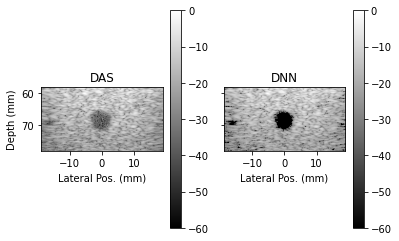

In [7]:
# MAKE IMAGES AND COMPUTE IMAGE QUALITY METRICS

# load in params file
f = h5py.File(os.path.join(test_data_path,test_data_name+'_params.mat'),'r')
beam_position_x = np.asarray(f['beam_position_x'])
t = np.asarray(f['t'])
fs = np.asarray(f['fs'])
c = np.asarray(f['c'])
mask_in = np.asarray(f['mask_in'])
mask_out = np.asarray(f['mask_out'])
f.close()
depths = t/fs*c/2

# make DAS image
bmode_scaled = bmode - np.max(bmode)
fig,axs = plt.subplots(nrows=1,ncols=2,sharey=True)
das_img=axs[0].imshow(np.moveaxis(bmode_scaled,0,1),cmap='gray',
                      aspect='equal',vmin=-60,vmax=0,
                      extent=[beam_position_x[0][0]*1000,
                              beam_position_x[-1][0]*1000,
                              depths[0][-1]*1000,
                              depths[0][0]*1000])
axs[0].set_title('DAS')
axs[0].set_ylabel('Depth (mm)')
axs[0].set_xlabel('Lateral Pos. (mm)')
fig.colorbar(das_img,ax=axs[0])

# make DNN image
bmode_dnn_scaled = bmode_dnn - np.max(bmode_dnn)
dnn_img=axs[1].imshow(np.moveaxis(bmode_dnn_scaled,0,1),cmap='gray',
                      aspect='equal',vmin=-60,vmax=0,
                      extent=[beam_position_x[0][0]*1000,
                              beam_position_x[-1][0]*1000,
                              depths[0][-1]*1000,
                              depths[0][0]*1000])
axs[1].set_title('DNN')
axs[1].set_xlabel('Lateral Pos. (mm)')

# add colorbar and save figure
fig.colorbar(dnn_img,ax=axs[1])
fig.savefig(os.path.join(model_path,test_data_name+'_result.png'))

# find indicies corresponding to inside and outside of lesion
idx_in = np.where(mask_in==1)
idx_out = np.where(mask_out==1)

# compute mean and variance for DAS
mean_in = np.mean(env[idx_in])
mean_out = np.mean(env[idx_out])
var_in = np.var(env[idx_in])
var_out = np.var(env[idx_out])

# compute mean and variance for DNN
mean_in_dnn = np.mean(env_dnn[idx_in])
mean_out_dnn = np.mean(env_dnn[idx_out])
var_in_dnn = np.var(env_dnn[idx_in])
var_out_dnn = np.var(env_dnn[idx_out])

# compute image quality metrics
CNR = 20*np.log10(np.abs(mean_in-mean_out)/np.sqrt(var_in+var_out))
CNR_DNN = 20*np.log10(np.abs(mean_in_dnn-mean_out_dnn)/
                      np.sqrt(var_in_dnn+var_out_dnn))
CR = -20*np.log10(np.abs(mean_in/mean_out))
CR_DNN = -20*np.log10(np.abs(mean_in_dnn/mean_out_dnn))
print('CNR DAS: {:.2f}'.format(CNR))
print('CNR DNN: {:.2f}'.format(CNR_DNN))
print('CR DAS: {:.2f}'.format(CR))
print('CR DNN: {:.2f}'.format(CR_DNN))